In [1]:
import numpy as np
import numpy.polynomial.polynomial as np_pp
#np.seterr(divide='ignore', invalid='ignore')
from IPython.display import display, Markdown, Latex
#import scipy.special as ss
import sympy as sp
import matplotlib.pyplot as plt

### Synthesis of Combline ~~and Capacitively Loaded Interdigital~~ Bandpass Filters of Arbitrary Bandwidth

https://ieeexplore.ieee.org/abstract/document/1127609
  
#### IV. Combline Filter Synthesis Example 

1) passband: ${f}_{1}=1.20\;GHz$, ${f}_{2}=1.80\;GHz$, $0.1\;dB$ ripple $({\epsilon}=0.1526)$;  
2) attenuation: ${A}_{H}=30\;dB$ for ${f}_{H}\ge 2.4\;GHz$; ${A}_{L}=20\;dB$ for ${f}_{L}\le 0.5\;GHz$;  
3) no spurious responses through the fourth harmonic; let ${f}_{S}=7.418\;GHz$.  

In [23]:
#IV. Combline Filter Synthesis Example                                               
#1)
f1 = 1.2e9
f2 = 1.8e9
ripple = 0.1 #dB
#2)
AH = 30     #High side attenuation in dB
fH = 2.4e9  #High side attenuation frequency   
AL = 20     #Los side attenuation in dB
fL = 0.5e9  #Low side attenuation frequency
#3)
fS = 7.418e9 #Stop band frequency
#In the paper, fS = 7.148GHz is incorrect

In [24]:
def Comb_Req_Order(f1, f2, ripple, AL, fL, AH, fH, fS):
    """
    This function takes in various filter specifications and returns the needed
    order, and other parameters
    
    f1: lower passband edge frequency
    f2: upper passband edge frequency
    ripple: inband ripple in dB
    AL: lowside rejection requirement
    fL: lowside rejection frequency
    AH: highside rejection requirement
    fH: highide rejection frequency
    fS: frequency to hold the highside rejection
    
    Table I of...
    "Synthesis of Combline and Capacitively Loaded Inter... of Arbitrary Bandwidth"         
    """
    e = np.sqrt(10**(ripple/10.0)-1)
    fo = (fH+fS)/2.0
    omega1 = np.tan(np.pi*f1/(2*fo))
    omega2 = np.tan(np.pi*f2/(2*fo))
    omegaL = np.tan(np.pi*fL/(2*fo))
    omegaH = np.tan(np.pi*fH/(2*fo))

    ZL = np.sqrt((omega2**2-omegaL**2)/(omega1**2-omegaL**2))
    ZH = np.sqrt((omegaH**2-omega2**2)/(omegaH**2-omega1**2))

    NL = 0.5*(1+(AL/10.0-np.log10(abs((ZL+omega2/omega1)/(ZL-omega2/omega1))) \
                 +np.log10(4.0/pow(e,2)))/np.log10(abs((ZL+1)/(ZL-1))))
    NH = 0.5*(1+(AH/10.0-np.log10(abs((ZH+omega2/omega1)/(ZH-omega2/omega1))) \
                 +np.log10(4.0/pow(e,2)))/np.log10(abs((ZH+1)/(ZH-1))))

    N_Order = int(np.ceil(max(NL,NH)))
    
    return N_Order, omega1, omega2, e, fo

In [25]:
#Equations for combline filters from Table I.
N_Order, omega1, omega2, e, fo = Comb_Req_Order(f1, f2, ripple, AL, fL, AH, fH, fS)

# print('N:      ', N_Order)
# print('Omega1: ', omega1)
# print('Omega2: ', omega2)
# print('e:      ', e)
# print('fo:     ', fo)

$Z_{i} = 1$, for poles at ${\infty}$.  $\;\;\;\;\;\;\;$ See equations(3)-(4)   
$Z_{i} = \displaystyle\frac{\Omega_2}{\Omega_1}$, for poles at DC.  $\;\;\;$See equations(3)-(4)    
  
Form the following polynomial for a combline filter:  
$\mathbf{E}+Z\mathbf{F} = \displaystyle\prod_{i = 0}^{2N-1}(Z+Z_i) = (Z+1)^{2N-1}\left[Z+\frac{\Omega_2}{\Omega_1}\right]$ $\;\;\;\;$See equation(5)  
  
$^*$All indices are starting from zero to match with python's convention  

In [26]:
def Comb_EpZF(N_Order, omega1, omega2):
    #EQN(5): Form the polynomial E+ZF
    lp_poly = np.array([1, 1])
    EpZF = np.array([1, omega2/omega1]) #EpZF will always have only 1 high pass pole 
    for i in range(2*N_Order-1):
        EpZF = np.polymul(EpZF, lp_poly)
    
    return EpZF

In [27]:
#EQN(5): Form the polynomial E+ZF   
EpZF = Comb_EpZF(N_Order, omega1, omega2)
#print('E + ZF: \n',EpZF)

Extract $\mathbf{E}$ from $\mathbf{E}+Z\mathbf{F}$. $\mathbf{E}$ is just the even order parts of $\mathbf{E}+Z\mathbf{F}$.   

Form the following polynomial:

$\mathbf{E} + \displaystyle\frac{Z\mathbf{F}}{\sqrt{1+{\epsilon}^{2}}}$ $\;\;\;\;$See equation(6)

In [28]:
def EpZF_rf(EpZF, e):    
    #EQN(6): Extract polynomial E and form the polynomial E+ZF/sqr(1+e^2)
    #Indicies in the multiplication in EQN(6) are shifted to 0 -> N_order-1
    E = np.copy(EpZF)
    EpZF_rf = np.copy(EpZF)
    # for i in range(1, 2*N_Order, 2):
    #     E[i] = 0
    #     EpZF_rf[i] = EpZF_rf[i]/np.sqrt(1+e**2)
    E[1::2] =0
    EpZF_rf[1::2] = EpZF_rf[1::2]/np.sqrt(1+e**2)
    
    return E, EpZF_rf

In [29]:
#EQN(6): Extract polynomial E and form the polynomial E+ZF/sqr(1+e^2)
E, EpZF_rf = EpZF_rf(EpZF, e)  

Find the roots of $\mathbf{E} + \displaystyle\frac{Z\mathbf{F}}{\sqrt{1+{\epsilon}^{2}}} = 0$.  
  
Form the product of second order polynomials from the roots.  
  
$\mathbf{E} + \displaystyle\frac{Z\mathbf{F}}{\sqrt{1+\epsilon^2}} = \displaystyle\prod_{i = 0}^{N-1}(Z^2+m_iZ+n_i)$ $\;\;\;\;$See equation(6)  
  
$^*$All indices are starting from zero to match with python's convention  

In [30]:
def EpZF_rf_Poly2(EpZF_rf):
    #EQN(6): Find the factored quadratics
    #Indicies in the multiplication in EQN(6) are shifted to 0 -> N_order-1
    EpZF_rf_fact = [] #list to store the factored quadratics
    EpZF_rf_roots = np.roots(EpZF_rf) #The roots should come in complex conjugate pairs
    
    N_Order = len(EpZF_rf)//2
    
    for i in range(N_Order):
        #assume the resulting roots are listed in ordered pairs of conjugate roots
        EpZF_rf_fact.append(np.real(np.polymul([1, -1*EpZF_rf_roots[2*i]], \
                                               [1, -1*EpZF_rf_roots[2*i+1]])))
        
    return EpZF_rf_fact

In [31]:
#EQN(6): Find the factored quadratics
EpZF_rf_fact = EpZF_rf_Poly2(EpZF_rf)

After obtaining the values of $m_i$ and $n_i$, find $p_i$, $q_i$, and $r_i$. See equation(7)

$M_i=2n_i-m_i^2$  
  
$N_i=n_i^2$  
  
$R_i=\sqrt{1+M_i+N_i}$  
  
$T_i=\sqrt{\Omega_2^4+\Omega_1^2\Omega_2^2M_i+\Omega_1^4N_i}$         
$\;$  
$\;$  
$p_i=\displaystyle\frac{\Omega_2^2+\Omega_1^2(1+M_i)}{T_i+\Omega_1^2R_i}$  
  
$r_i=\displaystyle\frac{M_i\Omega_2^2+(\Omega_1^2+\Omega_2^2)N_i}{T_i+\Omega_2^2R_i}$  
  
$q_i=\displaystyle\sqrt{\frac{r_i(r_i-M_ip_i)+N_ip_i^2}{T_iR_i}}$

In [32]:
def p_q_r_Array(EpZF_rf_fact, omega1, omega2):                       
    #EQN(7): Generate coefficients p, q, r(lower case gamma from paper)
    #Indicies in the multiplication are shifted to 0-N_order-1
    M = np.array([])
    N = np.array([])
    R = np.array([])
    T = np.array([])
    p = np.array([])
    q = np.array([])
    r = np.array([])
    
    N_Order = len(EpZF_rf_fact)
    
    for i in range(N_Order):
        M = np.append(M, 2*EpZF_rf_fact[i][2] - EpZF_rf_fact[i][1]**2)
        N = np.append(N, EpZF_rf_fact[i][2]**2)
        R = np.append(R, np.sqrt(1 + M[i]+N[i]))
        T = np.append(T, np.sqrt(omega2**4 + (omega1**2)*(omega2**2)*M[i] \
                                 + (omega1**4)*N[i]))
        p = np.append(p, (omega2**2 + (omega1**2)*(1+M[i])) \
                      /(T[i] + (omega1**2)*R[i]))
        r = np.append(r, (M[i]*(omega2**2) + (omega1**2 + omega2**2)*N[i]) \
                      /(T[i] + (omega2**2)*R[i]))    
        q = np.append(q, np.sqrt((r[i]*(r[i]-M[i]*p[i]) + N[i]*(p[i]**2))/(T[i]*R[i])))
    
    return p, q, r

In [33]:
#EQN(7): Generate coefficients p, q, r(lower case gamma from paper)
p, q, r = p_q_r_Array(EpZF_rf_fact, omega1, omega2)   

Find the polynomials $\mathbf{A}$ and $\mathbf{B}$.  

$\mathbf{A}+\mathbf{B}\sqrt{(Z^2-1)(\Omega_2^2-\Omega_1^2Z^2)} = \sqrt{1+\epsilon^2}\displaystyle\prod_{{i=0}}^{N-1}\left(p_iZ^2+q_i\sqrt{(Z^2-1)(\Omega_2^2-\Omega_1^2Z^2)}+r_i\right)$ $\;\;\;\;$See equation(8) 
  
Due to the $\sqrt{(Z^2-1)(\Omega_2^2-\Omega_1^2Z^2)}$ factor, the procedure for finding polynomials $\mathbf{A}$ and $\mathbf{B}$ is not straight forward.  
$\;$  
$\;$  
The method implemented here for evaluating $\mathbf{A}$ and $\mathbf{B}$ is the following:  
1. Using the function __prm()__, the permutations of the products of $p_i+q_i+r_i$ are formed.  
For example, if $N=3$, the output of __prm(3)__ would be [['$p$', 2, '$p$', 1, '$p$' ,0], ['$q$', 2, '$p$', 1, '$p$', 0], ...]  
2. Using __Sorted_Combo()__, each item from the output of __prm()__ is placed in a dictionary of lists where the keys correspond to the number of $q$'s in the item.  
For example, {0: [['$p$', 1, '$p$', 1, '$p$', 0, ...]], 1: [['$q$', 2, '$p$', 1, '$p$', 0, ...]], 2: [['$q$', 2, '$q$', 1, '$p$', 0, ...]], 3: [['$q$', 2, '$q$', 1, '$q$', 0]]}
3. Using __ApBsqrt_fact()__, $\mathbf{A}$ is formed by using the even keys from the output of __Sorted_Combo()__.  $\mathbf{B}$ is formed using the odd keys since the odd combinations of $q$'s will always contain the previously mentioned $\sqrt{(Z^2-1)(\Omega_2^2-\Omega_1^2Z^2)}$ factor.  
  
$^*$All indices are starting from zero to match with python's convention  

In [34]:
def prm(order):
    """
    Generate the permutations of the coefficients of  
    (p_0+q_0+r_0)(p_1+q_1+r_1)...(p_(order-1)+q_(order-1)+r_(order-1))
    
    This is useful in formulating eqn(8) from the Wenzel paper:
    "Synthesis of Combline and Capacitively Loaded Inter... of Arbitrary Bandwidth"         
    """
    if order==1:
        return [['p',0], ['q',0], ['r',0]]
    temp = []
    perm_list = prm(order-1)
    for item in perm_list:
        #print('item',item)
        for pqr in ('p', 'q', 'r'):
            item_new = item.copy()
            item_new.insert(0, order-1)
            item_new.insert(0, pqr)
            temp.append(item_new)         
    return temp


def form_poly(order, p, q, r, combo, omega1, omega2):
    """
    This function takes a a string in combo and forms a polynomial
    
    order: order of the filter
    p, q, r: numpy arrays of the coefficients p, q, and r
    combo: combination of p, q, and r.  ie 'p0q1r2' or order=3
    omega1, omega2: upper and lower passband frequencies
    
    This is useful in formulating eqn(8) from the Wenzel paper:
    "Synthesis of Combline and Capacitively Loaded Inter... of Arbitrary Bandwidth"         
    """
    #form the polynomial of z^2
    p_poly = np.array([1, 0, 0])
    #form the polynomial of (Z^2-1)(omega2^2-omega1^2Z^2)
    q_poly = np.polymul([1, 0, -1], [-1*omega1**2, 0, omega2**2])
    
    #initialize coefficient and order of p's and q's
    coef = 1   
    p_order = 0
    q_order = 0
    
    #order count and coefficient multiplication
    for i in range(0, 2*order, 2):
        if combo[i]=='p':
            p_order += 1
            coef *= p[int(combo[i+1])]
        if combo[i]=='q':
            q_order += 1
            coef *= q[int(combo[i+1])]
        if combo[i]=='r':
            coef *= r[int(combo[i+1])]
                        
    q_order = q_order//2 
    #q_order is halved each q corresponds to sqrt of of q_poly
    #integer division will result in correct order if q_order is odd

    #form the polynomial of the combination of combo     
    polynom = np.array([coef])
    for i in range(p_order):
        polynom = np.polymul(polynom, p_poly)
    for i in range(q_order):
        polynom = np.polymul(polynom, q_poly)
                      
    return polynom


def Sorted_Combo(N_Order):
    '''
    form the following list of lists:
    [ [ combos with no q ], [ combos with 1 q's ], 
    [ combos with 2 q's ], ...,[q(N_Order-1)q(N_Order-2)..q0] ]
    '''            
    #Helper func to generate polynomials A and B, EQN(8)
    combo_list = prm(N_Order)
    
    #Generate lists in a list where the indices of 
    #the lists correspond to the order of q's
    sorted_combo = {}
    for key in range(N_Order+1):
        sorted_combo[key] = []

    #counts the q's in each permutation and places 
    #each permutation into the corresponding lists  
    for combo in combo_list:
        count=0
        for letter in range(0, len(combo), 2):
            if combo[letter]=='q':
                count += 1
        sorted_combo[count].append(combo)
    
    return sorted_combo
    

def ApBsqrt_fact(N_Order, e, p, q, r, omega1, omega2, sorted_combo):     
    #EQN(8): Extract A and B from A+Bsqrt((Z^2-1)(omega^2-(omega1^2)(Z^2)))
    #Form the polynomial A
    A = np.array([])
    #Using only even order of q's
    for q_ord in range(0, len(sorted_combo), 2):
        for combination in sorted_combo[q_ord]:
            A = np.polyadd(A, form_poly(N_Order, p, q, r, combination, omega1, omega2))
    A = A*np.sqrt(1+e**2) 

    #Form the polynomial B
    B = np.array([])
    #Using only odd order of q's
    for q_ord in range(1, len(sorted_combo), 2):
        for combination in sorted_combo[q_ord]:
            B = np.polyadd(B, form_poly(N_Order, p, q, r, combination, omega1, omega2))
    B = B*np.sqrt(1+e**2)
    
    return A, B

In [35]:
#EQN(8): Extract A and B from A+Bsqrt((Z^2-1)(omega^2-(omega1^2)(Z^2)))      
sorted_combo = Sorted_Combo(N_Order)
A, B = ApBsqrt_fact(N_Order, e, p, q, r, omega1, omega2, sorted_combo)
#print(A)
#print(B)

With polynomials $\mathbf{A}$, $\mathbf{B}$, and $\mathbf{E}$, form the following polynomial:  

$\mathbf{Y}(Z^2)=\displaystyle\frac{\mathbf{A}+{\epsilon}\mathbf{E}}{\mathbf{B}(\Omega_2^2-\Omega_1^2Z^2)}$ $\;\;\;\;$See equation(9)  

In [36]:
def YofZ2(A, E, B, e, omega1, omega2):
    #EQN(9):Form polynomial Y(Z^2)'s numerator Yn=A+eE 
    #Form Y(Z^2)'s denominator Yd=B(omega2^2-omega1^2Z^2)
    YZn = np.polyadd(A, e*E)
    YZd = np.polymul(B, [-1*(omega1**2), 0, omega2**2])

    return YZn, YZd

In [37]:
#EQN(9):Form polynomial Y(Z^2)'s numerator Yn=A+eE 
YZn, YZd = YofZ2(A, E, B, e, omega1, omega2)

Convert from Z to S domain by the following substitution:  

$Z^2=\displaystyle\frac{S^2+\Omega_2^2}{S^2+\Omega_1^2}$ $\;\;\;\;$See equation(2)    
  
Find $\mathbf{Y}(S)$ using the following relationship:  

$\displaystyle\frac{\mathbf{Y}(S)}{S}=\mathbf{Y}(Z^2)$ $\;\;\;\;$See equation(9) 

In [38]:
def YofS(YZn, YZd, omega1, omega2):
    #Convert Y(Z^2) to Y(S)/S by using EQN(2)
    Z2n = np.array([1, 0, omega2**2])
    Z2d = np.array([1, 0, omega1**2])

    #Numerator and denominator of Y(Z^2) will have the same even order
    YSn = np.array([])
    YSd = np.array([])
    
    N_Order = len(YZd)//2
    for i in range(N_Order + 1):
        temp = np.polymul(np_pp.polypow(Z2n, N_Order - i), np_pp.polypow(Z2d, i)) 
        YSn = np.polyadd(YSn, YZn[2*i]*temp)   
        YSd = np.polyadd(YSd, YZd[2*i]*temp)

    #Ysd constant term is always zero and therefore..
    YSd = YSd[:-1]
    
    return YSn, YSd

In [39]:
#Convert Y(Z^2) to Y(S)/S by using EQN(2)
YSn, YSd = YofS(YZn, YZd, omega1, omega2)

Once $\mathbf{Y}(S)$ is obtained, the filter elements can then be extracted from $\mathbf{Y}(S)$.  
  
The element extraction process for a network with equal shunt capacitors is described in the paragraphs after equation(9).  It is further elaborated below:  

__Step 1__. A shunt capacitor $C_1$ is extracted from $\mathbf{Y}(S)$ leaving $\mathbf{Y}'(S)$  
  
__Step 2__. Shunt inductor $L_T$ is extracted from $\mathbf{Y}'(S)$ leaving $\mathbf{Y}''(S)$  
  
__Step 3__. A series inductor $L_{C1}'$ is removed from $\mathbf{Y}''(S)$ leaving $\displaystyle\frac{1}{\mathbf{Y}'''(S)}$ or $\mathbf{Z}'''(S)$  
  
__Step 4__. Shunt capcitor $C_2'$ is evaluated but not revomed from $\mathbf{Z}'''(S)$  
  
__Step 5__. Find the redundant circuit elements $L_1$ and $L_{C1}$ (notice the $'$ has disappeared) where  
  
$\;\;\;\;\;\;\;\;\;\;\;$ $L_1=\displaystyle\frac{L_T L_{C1}'}{L_{C1}'+\left(1-\sqrt{\displaystyle\frac{C_1}{C_2'}}\right)L_{T}}$  

$\;\;\;\;\;\;\;\;\;\;\;$ $L_{C1}=L_{C1}'\sqrt{\displaystyle\frac{C_2'}{C_1}}$  
  
  
$\;\;\;\;\;\;\;\;\;\;\;$ The factor $\sqrt{\displaystyle\frac{C_1}{C_2'}}$ is to keep all shunt capacitors equal in the final nonredundant network  

Steps 1-5 is implemented by the function __Comb_Non_Red_Extract()__  
  
__Step 6__. Go back to step 2 and perform the following steps starting from $\mathbf{Y}'(S)$:  

$\;\;\;\;\;\;\;$__Step 2__. Shunt inductor $L_1$ is partially extracted from $\mathbf{Y}'(S)$ leaving $\mathbf{Y}''(S)$  
$\;\;\;\;\;\;\;$__Step 3__. A series inductor $L_{C1}$ is removed from $\mathbf{Y}''(S)$ leaving $\displaystyle\frac{1}{\mathbf{Y}'''(S)}$ or $\mathbf{Z}'''(S)$  
Step 6 is implemented by the function __Comb_Red_Extract()__  
${\mathbf{Y}'''(S)}$ becomes ${\mathbf{Y}(S)}$ and steps 1-6 is repeated $N-1$ times until only a shunt inductor and a shunt capacitor is left  
  
__Step 7__. ${\mathbf{Y}'''(S)}$ becomes ${\mathbf{Y}(S)}$ and go back to step 1:  
  
$\;\;\;\;\;\;\;$__Step 1__. Shunt inductor $L_N$ is extracted from $\mathbf{Y}(S)$ leaving $\mathbf{Y}'(S)$  
$\;\;\;\;\;\;\;$__Step 2__. Shunt capacitor $C_N$ is extracted from $\mathbf{Y}'(S)$

In [40]:
def Comb_Non_Red_Extract(Yn, Yd, digs = 12):
    #Step 1: A shunt capacitor C1 is totally removed from Y(s) leaving Y'(s)
    #Yn/Yd
    Yn_div_Yd = np.polydiv(Yn, Yd)
    C1 = Yn_div_Yd[0][0]
    #Remainder function
    Yn_p = np.trim_zeros(np.round(np.copy(Yn_div_Yd[1]), digs), 'f')
    Yd_p = np.copy(Yd)
    
    #Step 2: The shunt inductor LT is totally removed from Y'(s) leaving Y''(s)
    #See Saal & Ulbrich extraction Figure 4
    #LT = 1/(sY'(s)), s->0
    LT = np.polyval(Yd_p[:-1], 0)/np.polyval(Yn_p, 0)
    #Remainder function
    Yn_pp = np.polysub(Yn_p, 1/LT*Yd_p[:-1])
    Yd_pp = np.copy(Yd_p)
    
    #Step 3: A series inductor LC1' is totally removed from Z''(S) leaving Z'''(S)
    Zn_pp = np.copy(Yd_pp)
    Zd_pp = np.trim_zeros(np.round(np.copy(Yn_pp), digs), 'f')
    LC1_p = Zn_pp[0]/Zd_pp[0]
    Zn_ppp = np.polysub(Zn_pp, np.polymul(Zd_pp, [LC1_p, 0]))
    Zd_ppp = np.copy(Zd_pp)
    
    #Step 4: The next shunt capacitor C2' is evaluated from Y'''(S)
    Yn_pppp = np.copy(Zd_ppp)
    Yd_pppp = np.trim_zeros(np.round(np.copy(Zn_ppp), digs), 'f')
    Yn_pppp_div_Yd_pppp = np.polydiv(Yn_pppp, Yd_pppp)
    C2_p = Yn_pppp_div_Yd_pppp[0][0]

    #Step 5: The redundant network element values are then C1, L1, LC1, where   
    L1 = LT*LC1_p/(LC1_p+(1-np.sqrt(C1/C2_p))*LT)
    LC1 = LC1_p*np.sqrt(C2_p/C1)
    #n = np.sqrt(C1/C2_p)
    
    return C1, L1, LC1, Yn_p, Yd_p

    
def Comb_Red_Extract(L1, LC1, Yn_p, Yd_p, digs = 12):
    #Step 6:
    #Repeat step 2: A shunt inductor L1 is partially removed from Y'(S) leaving Y''(S)
    #Remainder function. See Saal & Ulbrich extraction Figure 4.
    Yn_pp = np.polysub(Yn_p, 1/L1*Yd_p[:-1])
    Yd_pp = np.copy(Yd_p)
    #print('Red ',Yn_pp, Yd_pp)    
    
    #Repeat step 3: A series inductor LC1 is partially removed from Z''(S) leaving Z'''(S)
    Zn_pp = np.copy(Yd_pp)
    Zd_pp = np.trim_zeros(np.round(np.copy(Yn_pp), digs), 'f')
    #Remainder function.
    Zn_ppp = np.polysub(Zn_pp, np.polymul(Zd_pp, [LC1, 0]))
    Zd_ppp = np.copy(Zd_pp)
    #Convert to Y'''(S)
    Yn_ppp = np.copy(Zd_ppp)
    Yd_ppp = np.trim_zeros(np.round(np.copy(Zn_ppp), digs-2), 'f')
    #print('Red ',Yn_ppp, Yd_ppp) 
    
    return Yn_ppp, Yd_ppp
    

def Comb_CL_Extract(Yn, Yd, digs = 12):
    #Step 7:
    #Repeat step 1: A shunt capacitor C1 is totally removed from Y(s) leaving Y'(s)
    #Yn/Yd
    Yn_div_Yd = np.polydiv(Yn, Yd)
    C1 = Yn_div_Yd[0][0]
    #Remainder function
    Yn_p = np.trim_zeros(np.round(np.copy(Yn_div_Yd[1]), digs), 'f')
    Yd_p = np.copy(Yd)
    
    #Repeat step 2: The shunt inductor LT is totally removed from Y'(s) leaving Y''(s)
    #See Saal & Ulbrich extraction Figure 4
    #LT = 1/(sY'(s)), s->0
    LT = np.polyval(Yd_p[:-1], 0)/np.polyval(Yn_p, 0)
    #Remainder function
    Yn_pp = np.polysub(Yn_p, 1/LT*Yd_p[:-1])
    Yd_pp = np.copy(Yd_p)
    
    return C1, LT, Yn_pp, Yd_pp              
def Comb_Element_Extract(Yn, Yd, N_Order):                
    #Create empty component arrays
    cap_array = np.array([])
    ind_array = np.array([])

    #Extract components
    for ext in range(N_Order - 1):
        C, L, LC, Yn, Yd = Comb_Non_Red_Extract(Yn, Yd)
        
        #Update element array
        cap_array = np.append(cap_array, [C, np.inf])
        ind_array = np.append(ind_array, [L, LC])
    
        Yn, Yd = Comb_Red_Extract(L, LC, Yn, Yd) 

    #Extract remaining shunt L||C resonator    
    C, L, _, _ = Comb_CL_Extract(Yn, Yd)  

    #Update element array
    cap_array = np.append(cap_array, C)
    ind_array = np.append(ind_array, L)
    
    return cap_array, ind_array

In [41]:
#Extract capacitors and inductors for equal capacitor values
cap_array, ind_array = Comb_Element_Extract(YSn, YSd, N_Order)

print('N:           ',N_Order)
print('Shunt Caps:  ',cap_array[::2])
print('Shunt Inds:  ',ind_array[::2])
print('Series Inds: ',ind_array[1::2])

N:            3
Shunt Caps:   [4.2073454 4.2073454 4.2073454]
Shunt Inds:   [1.30028089 3.0501708  1.30028089]
Series Inds:  [1.99973049 1.99973049]


___

### Simulation of combline filter  
  
The extracted inductors and capacitor values are normalized to 1${\Omega}$ termination.  Also, they represent impedances of short and open commensurate length transmission lines.  To simulate the filter response, the components are treated as lumped elements and lambdified to ${\omega}$ with __SAPLad()__.  ${\omega}$ is then mapped to the interested frequency with Richards' transform,  

$S=j{\omega}=j\;tan\displaystyle\frac{\pi f}{2f_o}$ $\;\;\;$See equation(1)

In [42]:
def SAPLad(E, First_Element = 'shnt'):
    
    """
    S-parameter All Pole Ladder(SAPLad)
    Function for computing the S-Parameters of an all pole
    doubly terminated ladder network
    
    E = an array of network elements including the terminations
    First_Element = 'shnt'(shunt) or 'srs'(series)
    """
    
    w = sp.symbols('w')
    Rs = E[0][0]
    Rl = E[0][1]
    orientation = First_Element
    abcd = np.matrix([[1, 0], [0, 1]])
        
    for k in range(1, len(E)):
        if orientation == 'shnt':
            abcd = np.dot(abcd, np.matrix([[1, 0], [(1j*w*E[k][0]), 1]]))
            abcd = np.dot(abcd, np.matrix([[1, 0], [(1j*w*E[k][1])**-1, 1]]))
            orientation = 'srs'
        else:
            abcd = np.dot(abcd, np.matrix([[1, (1j*w*E[k][0])**-1], [0, 1]]))
            abcd = np.dot(abcd, np.matrix([[1, (1j*w*E[k][1])], [0, 1]]))
            orientation = 'shnt'

    abcd = np.dot(abcd, np.matrix([[np.sqrt(Rl/Rs), 0], [0, 1/np.sqrt(Rl/Rs)]]))
    
    A = abcd[0,0]
    B = abcd[0,1]
    C = abcd[1,0]
    D = abcd[1,1]
    
    denom = A+B/Rs+C*Rs+D
    S11_sym = (A+B/Rs-C*Rs-D)/denom
    S21_sym = 2/denom
    S12_sym = 2**(A*D-B*C)/denom
    S22_sym = (-A+B/Rs-C*Rs+D)/denom
    
    S11 = sp.lambdify(w, S11_sym, 'numpy')
    S21 = sp.lambdify(w, S21_sym, 'numpy')
    S12 = sp.lambdify(w, S12_sym, 'numpy')
    S22 = sp.lambdify(w, S22_sym, 'numpy')
    
    return np.array([S11, S21, S12, S22])


def Eval_Elements(cap_array, ind_array, w, terms=np.array([1,1])):
    '''
    Outputs the S21 and S11 in dB given abs(K(lambda))^2
    FnF: numerator of abs(K(lambda))^2
    PnF: denominator of abs(K(lambda))^2
    w: vector of omega for evaluation (rad)
    '''
           
    EE = np.array([[terms[0], terms[1]]])
    for i in range(len(cap_array)):
        EE = np.append(EE, [[cap_array[i], ind_array[i]]], axis = 0)
    #print(EE)  

    Sparm = SAPLad(EE)
    S11 = Sparm[0]
    S21 = Sparm[1]
   
    S11_dB = 20*np.log10(abs(S11(w)) + 1e-10) #1e-8 is added to prevent log(0) condition
    S21_dB = 20*np.log10(abs(S21(w)) + 1e-10) #1e-8 is added to prevent log(0) condition
    
    return S11_dB, S21_dB
    

def Plot_S(S11_dB, S21_dB, f, fs, rej_dB, title = '???', fig = 1):
    #test plot of transfer function 
    
    #plt.clf()
    #plt.close(fig)
    plt.figure(fig, (10, 6))
    plt.plot(f, S21_dB, label = '$|S_{21}|^2$')
    plt.plot(f, S11_dB, label = '$|S_{11}|^2$')
    plt.legend(loc = 'lower right', shadow=False, fontsize = 'large')
    
    #Y Limit
    As = -1*rej_dB
         
    #Limit the lower y-axis to 20dB below the rejection rounded to x10. E.g. 43->50
    plt.axis([0, f[-1], np.floor(As/10)*10-20, 0])
    plt.xticks(np.arange(0, f[-1]+1, 0.5))
    
    plt.xlabel('freq(GHz)', fontsize = 'large')
    plt.ylabel('(dB)', fontsize = 'large')
    plt.title(title, fontsize = 'large')
    
    plt.grid(b = bool)
    plt.show()

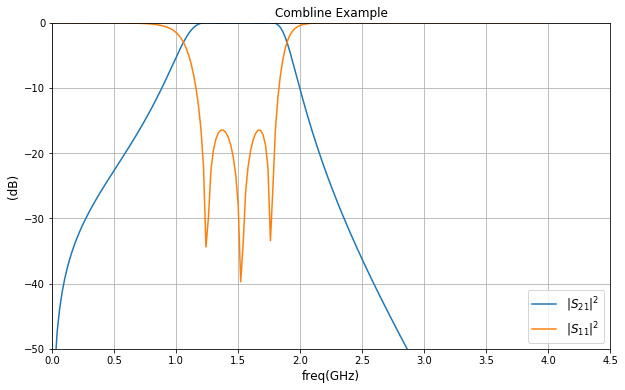

In [43]:
#Simulation frequency range in Hz
f = np.arange(20e6, 4e9, 20e6)

#Applying Richard's Transform
w = np.tan(np.pi/2*f/fo)

#Simulate using ABCD 
S11_dB, S21_dB = Eval_Elements(cap_array, ind_array, w)

#Normalize frequency to GHz and plot
fplot = f/1e9
Plot_S(S11_dB, S21_dB, fplot, fH/1e9, AH, 'Combline Example')

### As the number of resonators increase, the lambdification method of simulation becomes extremely time consuming.  Also, symmetry of the extracted values starts to deviate.  To be continued...